/tmp/ipykernel_22341/1514446559.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['A'].notna(), 'campaign'] = 'A'


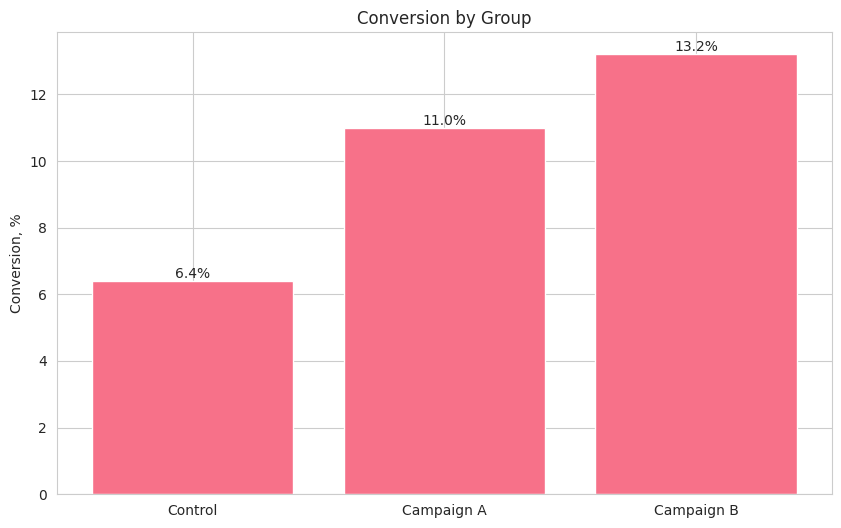

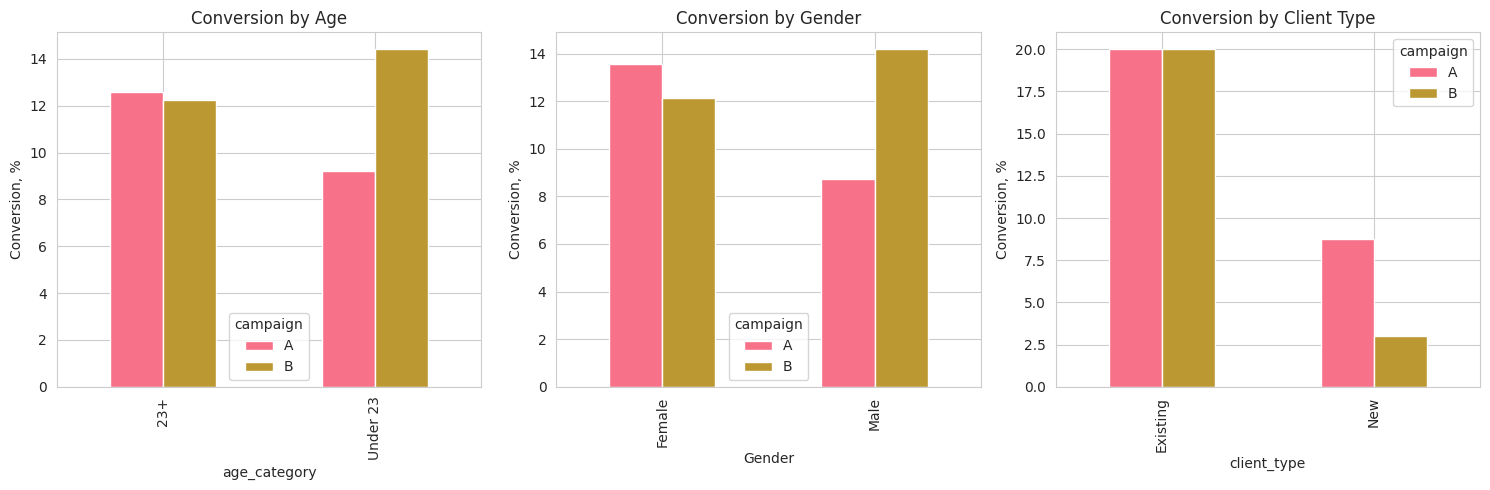

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("husl")
df = pd.read_csv('https://raw.githubusercontent.com/zalig/cu-datasets/main/advertisment.csv')

def prepare_data(df):
    df['campaign'] = np.nan
    df.loc[df['A'].notna(), 'campaign'] = 'A'
    df.loc[df['B'].notna(), 'campaign'] = 'B'
    
    df['purchased'] = df['Purchased'].notna()
    
    df['age_category'] = df['Age'].apply(lambda x: 'Under 23' if x < 23 else '23+')
    
    current_year = 2024
    df['client_type'] = df['ClientSince'].apply(
        lambda x: 'New' if x == current_year else 'Existing'
    )
    
    return df

df = prepare_data(df)

def calculate_conversion(data, group_col=None):
    if group_col:
        return data.groupby(group_col)['purchased'].agg(['count', 'mean']).round(4)
    return data['purchased'].mean()

def test_significance(group1, group2, alpha=0.05):
    contingency_table = pd.crosstab(
        pd.concat([group1, group2])['campaign'],
        pd.concat([group1, group2])['purchased']
    )
    result = stats.chi2_contingency(contingency_table)
    pvalue = result[1]
    return pvalue < alpha, pvalue

total_clients = len(df)
group_a = df[df['campaign'] == 'A']
group_b = df[df['campaign'] == 'B']
control_group = df[df['campaign'].isna()]

conv_total = calculate_conversion(df)
conv_a = calculate_conversion(group_a)
conv_b = calculate_conversion(group_b)
conv_control = calculate_conversion(control_group)

PROFIT_PER_CUSTOMER = 3000
AD_COST_PER_CUSTOMER = 80
TARGET_PROFIT_INCREASE = 300000

def calculate_campaign_metrics(group_size, natural_conv, campaign_conv, cost_per_customer):
    additional_conv = campaign_conv - natural_conv
    additional_purchases = group_size * additional_conv
    revenue = additional_purchases * PROFIT_PER_CUSTOMER
    costs = group_size * cost_per_customer
    profit = revenue - costs
    return {
        'additional_purchases': additional_purchases,
        'revenue': revenue,
        'costs': costs,
        'profit': profit
    }

metrics_a = calculate_campaign_metrics(
    len(control_group),
    conv_control,
    conv_a,
    AD_COST_PER_CUSTOMER
)

metrics_b = calculate_campaign_metrics(
    len(control_group),
    conv_control,
    conv_b,
    AD_COST_PER_CUSTOMER
)

def analyze_demographics(data, segment_col):
    return pd.crosstab(
        data[segment_col],
        data['campaign'],
        values=data['purchased'],
        aggfunc='mean'
    ).round(4)

age_analysis = analyze_demographics(df, 'age_category')
gender_analysis = analyze_demographics(df, 'Gender')
client_type_analysis = analyze_demographics(df, 'client_type')

def plot_conversion_rates():
    conv_data = {
        'Control': conv_control,
        'Campaign A': conv_a,
        'Campaign B': conv_b
    }
    plt.figure(figsize=(10, 6))
    plt.bar(conv_data.keys(), [v*100 for v in conv_data.values()])
    plt.title('Conversion by Group')
    plt.ylabel('Conversion, %')
    for i, v in enumerate(conv_data.values()):
        plt.text(i, v*100, f'{v*100:.1f}%', ha='center', va='bottom')
    plt.show()

def plot_demographic_analysis():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    (age_analysis * 100).plot(kind='bar', ax=ax1, title='Conversion by Age')
    (gender_analysis * 100).plot(kind='bar', ax=ax2, title='Conversion by Gender')
    (client_type_analysis * 100).plot(kind='bar', ax=ax3, title='Conversion by Client Type')
    
    ax1.set_ylabel('Conversion, %')
    ax2.set_ylabel('Conversion, %')
    ax3.set_ylabel('Conversion, %')
    
    plt.tight_layout()
    plt.show()

plot_conversion_rates()
plot_demographic_analysis()

def run_full_statistical_analysis():
    a_vs_control = test_significance(
        group_a[['campaign', 'purchased']],
        control_group[['campaign', 'purchased']]
    )
    
    b_vs_control = test_significance(
        group_b[['campaign', 'purchased']],
        control_group[['campaign', 'purchased']]
    )
    
    a_vs_b = test_significance(
        group_a[['campaign', 'purchased']],
        group_b[['campaign', 'purchased']]
    )
    
    return {
        'A_vs_Control': a_vs_control,
        'B_vs_Control': b_vs_control,
        'A_vs_B': a_vs_b
    }

statistical_results = run_full_statistical_analysis()

def generate_recommendations():
    recommendations = []
    
    if metrics_a['profit'] > metrics_b['profit']:
        better_campaign = 'A'
        profit_difference = metrics_a['profit'] - metrics_b['profit']
    else:
        better_campaign = 'B'
        profit_difference = metrics_b['profit'] - metrics_a['profit']
    
    recommendations.append(f"Campaign {better_campaign} is more profitable by ${profit_difference:,.0f}")
    
    segment_names = {
        'age_category': 'age group',
        'Gender': 'gender',
        'client_type': 'client type'
    }
    
    for segment, segment_name in segment_names.items():
        segment_analysis = analyze_demographics(df, segment)
        for group in segment_analysis.index:
            if segment_analysis.loc[group, 'A'] > segment_analysis.loc[group, 'B']:
                recommendations.append(f"Use campaign A for {segment_name} '{group}'")
            else:
                recommendations.append(f"Use campaign B for {segment_name} '{group}'")
    
    return recommendations

final_recommendations = generate_recommendations()

# PRESENTATION
https://docs.google.com/presentation/d/1ucED5x9WmO_IjE7g8WwneQgVnWudKeMgcwXg6w9bT3I/edit?usp=sharing